GitHub link for the talk. You can clone the data and play with it yourself. Please submit any improvements as pull requests

[https://github.com/jseabold/538model](https://github.com/jseabold/538model)

In [3]:
import datetime

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas
from scipy import stats
np.set_printoptions(precision=4, suppress=True)
pandas.set_printoptions(notebook_repr_html=False,
                        precision=4,
                        max_columns=12, column_space=10,
                        max_colwidth=25)

In [4]:
today = datetime.datetime(2012, 10, 2)

## Outline

Methodology was obtained from the old [538 Blog](http://www.fivethirtyeight.com/2008/03/frequently-asked-questions-last-revised.html) with updates at the [new site hosted by the New York Times](http://fivethirtyeight.blogs.nytimes.com/methodology/)

1. Polling Average: Aggregate polling data, and weight it according to our reliability scores.

2. Trend Adjustment: Adjust the polling data for current trends.

3. Regression: Analyze demographic data in each state by means of regression analysis.

4. Snapshot: Combine the polling data with the regression analysis to produce an electoral snapshot. This is our estimate of what would happen if the election were held today.

5. Projection: Translate the snapshot into a projection of what will happen in November, by allocating out undecided voters and applying a discount to current polling leads based on historical trends.

6. Simulation: Simulate our results 10,000 times based on the results of the projection to account for the uncertainty in our estimates. The end result is a robust probabilistic assessment of what will happen in each state as well as in the nation as a whole. 

## Get the Data

### Consensus forecast of GDP growth over the next two economic quarters <br />(Median of WSJ's monthly forecasting panel)

The process for creating an economic index for the 538 model is described [here](http://fivethirtyeight.blogs.nytimes.com/2012/07/05/measuring-the-effect-of-the-economy-on-elections/#more-31732).

In [5]:
forecasts = pandas.read_table("/home/skipper/school/seaboldgit/"
                              "talks/pydata/data/wsj_forecast.csv", skiprows=2)

In [6]:
forecasts

                  Forecaster               Institution  Q3 2012  Q4 2012
0              Paul Ashworth         Capital Economics      2.0      1.5
1          Nariman Behravesh        IHS Global Insight      1.5      1.6
2   Richard Berner/ David...            Morgan Stanley      NaN      NaN
3            Ram Bhagavatula     Combinatorics Capital      2.0      4.0
4          Beth Ann Bovino *       Standard and Poor's      NaN      NaN
5              Jay Brinkmann  Mortgage Bankers Asso...      1.8      1.9
6              Michael Carey       Credit Agricole CIB      1.7      1.6
7              Joseph Carson         AllianceBernstein      2.5      3.5
8             Julia Coronado               BNP Paribas      1.4      1.6
9              Mike Cosgrove                Econoclast      1.6      1.6
10              Lou Crandall            Wrightson ICAP      1.8      1.8
11            J. Dewey Daane     Vanderbilt University      1.5      1.5
12            Douglas Duncan                Fannie 

In [7]:
forecasts.rename(columns={"Q3 2012" : "gdp_q3_2012", 
                          "Q4 2012" : "gdp_q4_2012"}, inplace=True)

                  Forecaster               Institution  gdp_q3_2012  gdp_q4_2012
0              Paul Ashworth         Capital Economics          2.0          1.5
1          Nariman Behravesh        IHS Global Insight          1.5          1.6
2   Richard Berner/ David...            Morgan Stanley          NaN          NaN
3            Ram Bhagavatula     Combinatorics Capital          2.0          4.0
4          Beth Ann Bovino *       Standard and Poor's          NaN          NaN
5              Jay Brinkmann  Mortgage Bankers Asso...          1.8          1.9
6              Michael Carey       Credit Agricole CIB          1.7          1.6
7              Joseph Carson         AllianceBernstein          2.5          3.5
8             Julia Coronado               BNP Paribas          1.4          1.6
9              Mike Cosgrove                Econoclast          1.6          1.6
10              Lou Crandall            Wrightson ICAP          1.8          1.8
11            J. Dewey Daane

In [8]:
forecasts

                  Forecaster               Institution  gdp_q3_2012  gdp_q4_2012
0              Paul Ashworth         Capital Economics          2.0          1.5
1          Nariman Behravesh        IHS Global Insight          1.5          1.6
2   Richard Berner/ David...            Morgan Stanley          NaN          NaN
3            Ram Bhagavatula     Combinatorics Capital          2.0          4.0
4          Beth Ann Bovino *       Standard and Poor's          NaN          NaN
5              Jay Brinkmann  Mortgage Bankers Asso...          1.8          1.9
6              Michael Carey       Credit Agricole CIB          1.7          1.6
7              Joseph Carson         AllianceBernstein          2.5          3.5
8             Julia Coronado               BNP Paribas          1.4          1.6
9              Mike Cosgrove                Econoclast          1.6          1.6
10              Lou Crandall            Wrightson ICAP          1.8          1.8
11            J. Dewey Daane

In [9]:
median_forecast = forecasts[['gdp_q3_2012', 'gdp_q4_2012']].median()

In [10]:
median_forecast

gdp_q3_2012    1.8
gdp_q4_2012    1.8

### Economics State Variables from FRED

Job Growth (Nonfarm-payrolls) **PAYEMS** <br />
Personal Income **PI** <br />
Industrial production **INDPRO** <br />
Consumption **PCEC96** <br />
Inflation **CPIAUCSL** <br />

In [11]:
from pandas.io.data import DataReader

In [12]:
series = dict(jobs = "PAYEMS",
              income = "PI",
              prod = "INDPRO",
              cons = "PCEC96",
              prices = "CPIAUCSL")

In [13]:
#indicators = []
#for variable in series:
#    data = DataReader(series[variable], "fred", start="2010-1-1")
#    # renaming not necessary in master
#    data.rename(columns={"VALUE" : variable}, inplace=True)
#    indicators.append(data)

In [14]:
#indicators = pandas.concat(indicators, axis=1)

In [15]:
#indicators

### Polling Data

I used Python to scrape the [Real Clear Politics](realclearpolitics.com) website and download data for the 2004 and 2008 elections. The scraping scripts are available in the github repository for this talk. State by state historical data for the 2004 and 2008 Presidential elections was obtained from [electoral-vote.com](www.electorical-vote.com).

## Polling Average

Details can be found at the 538 blog [here](http://www.fivethirtyeight.com/2008/03/pollster-ratings-updated.html).

In [16]:
tossup = ["Colorado", "Florida", "Iowa", "New Hampshire", "Nevada", 
          "Ohio", "Virginia", "Wisconsin"]

In [17]:
national_data2012 = pandas.read_table("/home/skipper/school/seaboldgit/talks/pydata/"
                                      "data/2012_poll_data.csv")

In [18]:
national_data2012

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 289
Data columns:
Poll          290  non-null values
Date          290  non-null values
Sample        290  non-null values
MoE           290  non-null values
Obama (D)     290  non-null values
Romney (R)    290  non-null values
Spread        290  non-null values
dtypes: float64(2), object(5)

In [19]:
national_data2012.rename(columns={"Poll" : "Pollster"}, inplace=True)
national_data2012["obama_spread"] = national_data2012["Obama (D)"] - national_data2012["Romney (R)"]

In [20]:
national_data2012["State"] = "USA"

In [21]:
state_data2012 = pandas.read_table("/home/skipper/school/seaboldgit/talks/pydata/data/2012_poll_data_states.csv")
state_data2012

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 0 to 766
Data columns:
Date          767  non-null values
MoE           767  non-null values
Obama (D)     767  non-null values
Poll          767  non-null values
Romney (R)    767  non-null values
Sample        767  non-null values
Spread        767  non-null values
State         767  non-null values
dtypes: float64(2), object(6)

In [22]:
state_data2012["obama_spread"] = state_data2012["Obama (D)"] - state_data2012["Romney (R)"]

In [23]:
state_data2012.rename(columns=dict(Poll="Pollster"), inplace=True);

In [24]:
state_data2012.MoE

0      --
1     4.5
2     4.6
3     5.0
4     4.4
5     4.4
6     4.0
7     3.0
8     5.0
9     4.4
10    4.2
11    2.8
12    4.2
13    5.0
14    4.3
...
752    2.8
753     --
754    4.0
755    3.8
756    4.5
757    4.5
758    5.0
759    3.2
760    4.5
761    4.5
762    2.4
763    3.4
764    2.9
765    3.5
766    3.4
Name: MoE, Length: 767

In [25]:
state_data2012.MoE = state_data2012.MoE.replace("--", "nan").astype(float)

In [26]:
state_data2012

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 0 to 766
Data columns:
Date            767  non-null values
MoE             736  non-null values
Obama (D)       767  non-null values
Pollster        767  non-null values
Romney (R)      767  non-null values
Sample          767  non-null values
Spread          767  non-null values
State           767  non-null values
obama_spread    767  non-null values
dtypes: float64(4), object(5)

In [27]:
state_data2012 = state_data2012.set_index(["Pollster", "State", "Date"]).drop("RCP Average", level=0).reset_index()

In [28]:
state_data2012.head(5)

            Pollster State         Date  MoE  Obama (D)  Romney (R)  Sample     Spread  obama_spread
0  Rasmussen Reports    WA  9/26 - 9/26  4.5         52          41  500 LV  Obama +11            11
1   Gravis Marketing    WA  9/21 - 9/22  4.6         56          39  625 LV  Obama +17            17
2         Elway Poll    WA   9/9 - 9/12  5.0         53          36  405 RV  Obama +17            17
3          SurveyUSA    WA    9/7 - 9/9  4.4         54          38  524 LV  Obama +16            16
4          SurveyUSA    WA    8/1 - 8/2  4.4         54          37  524 LV  Obama +17            17

Clean up the sample numbers to make it a number.

In [29]:
state_data2012.Sample

0      500 LV
1      625 LV
2      405 RV
3      524 LV
4      524 LV
5      630 RV
6     1073 RV
7      408 RV
8      500 LV
9      557 RV
10    1264 RV
11     572 RV
12     405 RV
13     549 LV
14     469 RV
...
724     600 LV
725    1224 RV
726     625 LV
727     656 LV
728     500 LV
729     500 LV
730     450 LV
731     934 RV
732     500 LV
733     500 LV
734    1625 RV
735     819 RV
736    1176 RV
737     796 LV
738     817 RV
Name: Sample, Length: 739

In [30]:
state_data2012.Sample = state_data2012.Sample.str.replace("\s*([L|R]V)|A", "") # 20 RV
state_data2012.Sample = state_data2012.Sample.str.replace("\s*--", "nan") # --
state_data2012.Sample = state_data2012.Sample.str.replace("^$", "nan")

national_data2012.Sample = national_data2012.Sample.str.replace("\s*([L|R]V)|A", "") # 20 RV
national_data2012.Sample = national_data2012.Sample.str.replace("\s*--", "nan") # --
national_data2012.Sample = national_data2012.Sample.str.replace("^$", "nan")


In [31]:
state_data2012.Sample.astype(float)

0      500
1      625
2      405
3      524
4      524
5      630
6     1073
7      408
8      500
9      557
10    1264
11     572
12     405
13     549
14     469
...
724     600
725    1224
726     625
727     656
728     500
729     500
730     450
731     934
732     500
733     500
734    1625
735     819
736    1176
737     796
738     817
Name: Sample, Length: 739

In [32]:
state_data2012.Sample = state_data2012.Sample.astype(float)
national_data2012.Sample = national_data2012.Sample.astype(float)

The 2012 data is currently in order of time by state but doesn't have any years.

In [33]:
#dates2012.get_group(("OH", "NBC News/Marist"))

In [34]:
state_data2012["start_date"] = ""
state_data2012["end_date"] = ""
dates2012 = state_data2012.groupby(["State", "Pollster"])["Date"]
for _, date in dates2012:
    year = 2012
    # checked by hand, none straddle years
    changes = np.r_[False, np.diff(map(int, [i[0].split('/')[0] for 
                    i in date.str.split(' - ')])) > 0]
    for j, (idx, dt) in enumerate(date.iteritems()):
        dt1, dt2 = dt.split(" - ")
        year -= changes[j]
        # check for ones that haven't polled in a year - soft check
        # could be wrong for some...
        if year == 2012 and (int(dt1.split("/")[0]) > today.month and 
                             int(dt1.split("/")[1]) > today.day):
            year -= 1
        dt1 += "/" + str(year)
        dt2 += "/" + str(year)
        state_data2012.set_value(idx, "start_date", dt1)
        state_data2012.set_value(idx, "end_date", dt2)

In [35]:
national_data2012["start_date"] = ""
national_data2012["end_date"] = ""
dates2012 = national_data2012.groupby(["Pollster"])["Date"]
for _, date in dates2012:
    year = 2012
    # checked by hand, none straddle years
    changes = np.r_[False, np.diff(map(int, [i[0].split('/')[0] for 
                    i in date.str.split(' - ')])) > 0]
    for j, (idx, dt) in enumerate(date.iteritems()):
        dt1, dt2 = dt.split(" - ")
        year -= changes[j]
        dt1 += "/" + str(year)
        dt2 += "/" + str(year)
        national_data2012.set_value(idx, "start_date", dt1)
        national_data2012.set_value(idx, "end_date", dt2)

In [36]:
state_data2012.head(10)

             Pollster State         Date  MoE  Obama (D)  Romney (R)  Sample     Spread  obama_spread start_date   end_date
0   Rasmussen Reports    WA  9/26 - 9/26  4.5         52          41     500  Obama +11            11  9/26/2012  9/26/2012
1    Gravis Marketing    WA  9/21 - 9/22  4.6         56          39     625  Obama +17            17  9/21/2012  9/22/2012
2          Elway Poll    WA   9/9 - 9/12  5.0         53          36     405  Obama +17            17   9/9/2012  9/12/2012
3           SurveyUSA    WA    9/7 - 9/9  4.4         54          38     524  Obama +16            16   9/7/2012   9/9/2012
4           SurveyUSA    WA    8/1 - 8/2  4.4         54          37     524  Obama +17            17   8/1/2012   8/2/2012
5           SurveyUSA    WA  7/16 - 7/18  4.0         46          37     630   Obama +9             9  7/16/2012  7/18/2012
6             PPP (D)    WA  6/14 - 6/17  3.0         54          41    1073  Obama +13            13  6/14/2012  6/17/2012
7       

In [37]:
state_data2012.start_date = state_data2012.start_date.apply(pandas.datetools.parse)
state_data2012.end_date = state_data2012.end_date.apply(pandas.datetools.parse)

national_data2012.start_date = national_data2012.start_date.apply(pandas.datetools.parse)
national_data2012.end_date = national_data2012.end_date.apply(pandas.datetools.parse)

In [38]:
def median_date(row):
    dates = pandas.date_range(row["start_date"], row["end_date"])
    median_idx = int(np.median(range(len(dates)))+.5)
    return dates[median_idx]
    
state_data2012["poll_date"] = [median_date(row) for i, row in state_data2012.iterrows()]
del state_data2012["Date"]
del state_data2012["start_date"]
del state_data2012["end_date"]

national_data2012["poll_date"] = [median_date(row) for i, row in national_data2012.iterrows()]
del national_data2012["Date"]
del national_data2012["start_date"]
del national_data2012["end_date"]

In [39]:
state_data2012.head(5)

            Pollster State  MoE  Obama (D)  Romney (R)  Sample     Spread  obama_spread            poll_date
0  Rasmussen Reports    WA  4.5         52          41     500  Obama +11            11  2012-09-26 00:00:00
1   Gravis Marketing    WA  4.6         56          39     625  Obama +17            17  2012-09-22 00:00:00
2         Elway Poll    WA  5.0         53          36     405  Obama +17            17  2012-09-11 00:00:00
3          SurveyUSA    WA  4.4         54          38     524  Obama +16            16  2012-09-08 00:00:00
4          SurveyUSA    WA  4.4         54          37     524  Obama +17            17  2012-08-02 00:00:00

In [40]:
pollsters = state_data2012.Pollster.unique()
pollsters.sort()

In [41]:
len(pollsters)

120

In [42]:
print pandas.Series(pollsters)

0              AFP/Magellan (R)
1            AIF/McLaughlin (R)
2                           ARG
3          Albuquerque Journal*
4                 Arizona State
5                 Baltimore Sun
6            Baydoun/Foster (D)
7      Behavior Research Center
8                Bloomberg News
9                  Boston Globe
10           CBS/NYT/Quinnipiac
11         CNN/Opinion Research
12                     CNN/Time
13           CNU/Times-Dispatch
14     Caddell/McLaughlin/SA...
15      Castleton State College
16              Chicago Tribune
17                  Civitas (R)
18              Clarus Research
19           Columbus Dispatch*
20     Courier-Journal/Surve...
21            Critical Insights
22            Daily Kos/PPP (D)
23                    Dartmouth
24        Denver Post/SurveyUSA
25          Des Moines Register
26                 Deseret News
27             Deseret News/KSL
28                 Detroit News
29                     EPIC-MRA
30     Elon Univ./Charlotte ...
31      

### 538 Pollster Ratings

In [43]:
weights = pandas.read_table("/home/skipper/school/seaboldgit/talks/pydata/data/pollster_weights.csv")

In [44]:
weights

                    Pollster  Weight   PIE
0      ABC / Washington Post    0.95  1.41
1    American Research Group    0.65  1.76
2       CBS / New York Times    0.66  1.84
3   Chicago Trib. / Marke...    1.16  1.13
4     CNN / Opinion Research    0.77  1.59
5     Columbus Dispatch (OH)    0.50  6.76
6                   EPIC-MRA    0.75  1.65
7   Fairleigh-Dickinson (NJ)    0.71  1.72
8            Field Poll (CA)    1.33  0.88
9     Fox / Opinion Dynamics    0.79  1.60
10      Franklin Pierce (NH)    0.74  1.60
11         Insider Advantage    0.95  1.29
12             Keystone (PA)    0.64  1.55
13      LA Times / Bloomberg    0.83  1.44
14               Marist (NY)    0.69  1.73
15               Mason-Dixon    1.10  1.15
16                  Mitchell    0.96  1.43
17                 Ohio Poll    1.24  1.05
18  Public Opinion Strate...    0.63  1.81
19  Public Policy Polling...    1.05  1.60
20                Quinnipiac    0.95  1.34
21                 Rasmussen    1.30  0.88
22         

In [45]:
weights.mean()

Weight    0.908
PIE       1.707

Clean up the pollster names a bit so we can merge with the weights.

In [46]:
import pickle
pollster_map = pickle.load(open("/home/skipper/school/seaboldgit/talks/pydata/data/pollster_map.pkl", "rb"))

In [47]:
state_data2012.Pollster.replace(pollster_map, inplace=True);

In [48]:
national_data2012.Pollster.replace(pollster_map, inplace=True);

Inner merge the data with the weights

In [49]:
state_data2012 = state_data2012.merge(weights, how="inner", on="Pollster")

In [50]:
state_data2012.head(5)

                  Pollster State  MoE  Obama (D)  Romney (R)  Sample    Spread  obama_spread            poll_date  Weight   PIE
0  American Research Group    FL  4.0         50          45     600  Obama +5             5  2012-09-21 00:00:00    0.65  1.76
1  American Research Group    NH  4.0         50          45     600  Obama +5             5  2012-09-26 00:00:00    0.65  1.76
2  American Research Group    NH  4.5         48          47     463  Obama +1             1  2012-09-16 00:00:00    0.65  1.76
3  American Research Group    NH  4.2         49          46     417  Obama +3             3  2012-06-23 00:00:00    0.65  1.76
4  American Research Group    NH  4.2         48          41     557  Obama +7             7  2012-03-17 00:00:00    0.65  1.76

#### First, we average each pollster for each state.

The first adjustment is an exponential decay for recency of the poll. Based on research in prior elections, a weight with a half-life of 30 days since the median date the poll has been in the field is assigned to each poll.

In [51]:
def exp_decay(days):
    # defensive coding, accepts timedeltas
    days = getattr(days, "days", days)
    return .5 ** (days/30.)

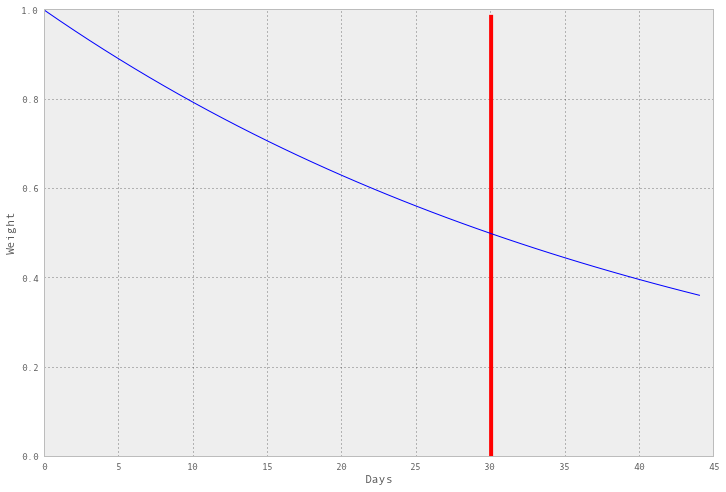

In [52]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={"xlabel" : "Days",
                                                   "ylabel" : "Weight"})
days = np.arange(0, 45)
ax.plot(days, exp_decay(days));
ax.vlines(30, 0, .99, color='r', linewidth=4)
ax.set_ylim(0,1)
ax.set_xlim(0, 45);

The second adjustment is for the sample size of the poll. Polls with a higher sample size receive a higher weight.

Binomial sampling error = +/- $50 * \frac{1}{\sqrt{nobs}}$ where the 50 depends on the underlying probability or population preferences, in this case assumed to be 50:50 (another way of calculating Margin of Error)

In [53]:
def average_error(nobs, p=50.):
    return p*nobs**-.5

The thinking here is that having 5 polls of 1200 is a lot like having one poll of 6000. However, we downweight older polls by only including the marginal effective sample size. Where the effective sample size is the size of the methodologically perfect poll for which we would be indifferent between it and the one we have with our current total error. Total error is determined as $TE = \text{Average Error} + \text{Long Run Pollster Induced Error}$. See [here](http://www.fivethirtyeight.com/2008/04/pollster-ratings-v30.html) for the detailed calculations of Pollster Induced Error.

In [54]:
def effective_sample(total_error, p=50.):
    return p**2 * (total_error**-2.)

In [55]:
state_pollsters = state_data2012.groupby(["State", "Pollster"])

In [56]:
ppp_az = state_pollsters.get_group(("AZ", "Public Policy Polling (PPP)"))

In [57]:
var_idx = ["Pollster", "State", "Obama (D)", "Romney (R)", "Sample", "poll_date"]
ppp_az[var_idx]

                     Pollster State  Obama (D)  Romney (R)  Sample            poll_date
198  Public Policy Polling...    AZ         44          53     993  2012-09-08 00:00:00
199  Public Policy Polling...    AZ         41          52     833  2012-07-24 00:00:00
200  Public Policy Polling...    AZ         43          50     500  2012-05-19 00:00:00
201  Public Policy Polling...    AZ         47          47     743  2012-02-18 00:00:00
202  Public Policy Polling...    AZ         42          49     500  2011-11-19 00:00:00
203  Public Policy Polling...    AZ         44          48     623  2011-04-30 00:00:00
204  Public Policy Polling...    AZ         43          49     599  2011-01-29 00:00:00
205  Public Policy Polling...    AZ         43          50     617  2010-09-20 00:00:00

In [58]:
ppp_az.sort("poll_date", ascending=False, inplace=True);

In [59]:
ppp_az["cumulative"] = ppp_az["Sample"].cumsum()
ppp_az["average_error"] = average_error(ppp_az["cumulative"])
ppp_az["total_error"] = ppp_az["PIE"] + ppp_az["average_error"]
ppp_az[var_idx + ["cumulative"]]

                     Pollster State  Obama (D)  Romney (R)  Sample            poll_date  cumulative
198  Public Policy Polling...    AZ         44          53     993  2012-09-08 00:00:00         993
199  Public Policy Polling...    AZ         41          52     833  2012-07-24 00:00:00        1826
200  Public Policy Polling...    AZ         43          50     500  2012-05-19 00:00:00        2326
201  Public Policy Polling...    AZ         47          47     743  2012-02-18 00:00:00        3069
202  Public Policy Polling...    AZ         42          49     500  2011-11-19 00:00:00        3569
203  Public Policy Polling...    AZ         44          48     623  2011-04-30 00:00:00        4192
204  Public Policy Polling...    AZ         43          49     599  2011-01-29 00:00:00        4791
205  Public Policy Polling...    AZ         43          50     617  2010-09-20 00:00:00        5408

In [60]:
ppp_az["ESS"] = effective_sample(ppp_az["total_error"])
ppp_az["MESS"] = ppp_az["ESS"].diff()
# fill in first one
ppp_az["MESS"].fillna(ppp_az["ESS"].head(1).item(), inplace=True);

In [61]:
ppp_az[["poll_date", "Sample", "cumulative", "ESS", "MESS"]]

               poll_date  Sample  cumulative      ESS     MESS
198  2012-09-08 00:00:00     993         993  246.182  246.182
199  2012-07-24 00:00:00     833        1826  325.801   79.618
200  2012-05-19 00:00:00     500        2326  359.591   33.791
201  2012-02-18 00:00:00     743        3069  399.185   39.594
202  2011-11-19 00:00:00     500        3569  420.968   21.783
203  2011-04-30 00:00:00     623        4192  444.241   23.273
204  2011-01-29 00:00:00     599        4791  463.531   19.291
205  2010-09-20 00:00:00     617        5408  480.955   17.424

Now let's do it for every polling firm in every state.

In [62]:
def calculate_mess(group):
    cumulative = group["Sample"].cumsum()
    ae = average_error(cumulative)
    total_error = ae + group["PIE"]
    ess = effective_sample(total_error)
    mess = ess.diff()
    mess.fillna(ess.head(1).item(), inplace=True)
    #from IPython.core.debugger import Pdb; Pdb().set_trace()
    return pandas.concat((ess, mess), axis=1)

#state_data2012["ESS", "MESS"] 
df = state_pollsters.apply(calculate_mess)
df.rename(columns={0 : "ESS", 1 : "MESS"}, inplace=True);

In [63]:
state_data2012 = state_data2012.join(df)

Give them the time weight

In [64]:
td = today - state_data2012["poll_date"].head(1).item()

In [65]:
state_data2012["poll_date"].head(1).item()

<Timestamp: 2012-09-21 00:00:00>

In [66]:
td

datetime.timedelta(11)

In [67]:
state_data2012["time_weight"] = (today - state_data2012["poll_date"]).apply(exp_decay)

Now aggregate all of these. Weight them based on the sample size but also based on the time_weight.

In [68]:
def weighted_mean(group):
    weights1 = group["time_weight"]
    weights2 = group["MESS"]
    return np.sum(weights1*weights2*group["obama_spread"]/(weights1*weights2).sum())

In [69]:
state_pollsters = state_data2012.groupby(["State", "Pollster"])
state_polls = state_pollsters.apply(weighted_mean)

In [70]:
state_polls

State  Pollster                    
AZ     Public Policy Polling (PPP)     -9.168
       Rasmussen                      -10.209
CA     Field Poll (CA)                 23.344
       Public Policy Polling (PPP)     20.999
       Rasmussen                       22.000
       SurveyUSA                       22.123
CO     American Research Group          2.000
       Public Policy Polling (PPP)      5.470
       Rasmussen                       -1.574
CT     Public Policy Polling (PPP)     12.758
       Quinnipiac                       7.294
       Rasmussen                        8.000
FL     American Research Group          5.000
       Mason-Dixon                     -3.543
       Public Policy Polling (PPP)      3.125
       Quinnipiac                       3.076
       Rasmussen                        0.883
       Suffolk (NH/MA)                 -0.003
       SurveyUSA                        4.169
GA     Insider Advantage              -19.174
       Mason-Dixon                    -17.00

### 2004 and 2008 Polls

In [71]:
state_data2004 = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/2004-pres-polls.csv")
state_data2004

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 0 to 878
Data columns:
State       879  non-null values
Kerry       879  non-null values
Bush        879  non-null values
Date        879  non-null values
Pollster    879  non-null values
dtypes: int64(2), object(3)

In [72]:
state_data2004.head(5)

  State  Kerry  Bush    Date        Pollster
0    AL     39    57  Oct 25       SurveyUSA
1    AL     32    56  Oct 12  Capital Survey
2    AL     34    62  Oct 01       SurveyUSA
3    AL     40    54  Sep 14             ARG
4    AL     42    53  Sep 06       Rasmussen

In [73]:
state_data2008 = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/2008-pres-polls.csv")
state_data2008

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189 entries, 0 to 1188
Data columns:
State       1189  non-null values
Obama       1189  non-null values
McCain      1189  non-null values
Start       1189  non-null values
End         1189  non-null values
Pollster    1189  non-null values
dtypes: int64(2), object(4)

In [74]:
state_data2008.head(5)

  State  Obama  McCain   Start     End        Pollster
0    AL     36      61  Oct 27  Oct 28       SurveyUSA
1    AL     34      54  Oct 15  Oct 16  Capital Survey
2    AL     35      62  Oct 08  Oct 09       SurveyUSA
3    AL     35      55  Oct 06  Oct 07  Capital Survey
4    AL     39      60  Sep 22  Sep 22       Rasmussen

In [75]:
state_data2008.End + " 2008"

0     Oct 28 2008
1     Oct 16 2008
2     Oct 09 2008
3     Oct 07 2008
4     Sep 22 2008
5     Sep 17 2008
6     Sep 16 2008
7     Sep 15 2008
8     Sep 09 2008
9     Aug 04 2008
10    Jul 31 2008
11    Jun 26 2008
12    Jun 26 2008
13    Jun 02 2008
14    May 27 2008
...
1174    May 05 2008
1175    Apr 24 2008
1176    Apr 13 2008
1177    Apr 05 2008
1178    Mar 26 2008
1179    Mar 16 2008
1180    Feb 28 2008
1181    Feb 21 2008
1182    Feb 17 2008
1183    Oct 19 2008
1184    Oct 14 2008
1185    Sep 11 2008
1186    Sep 10 2008
1187    Aug 15 2008
1188    Feb 28 2008
Name: End, Length: 1189

In [76]:
(state_data2008.End + " 2008").apply(pandas.datetools.parse)

0     2008-10-28 00:00:00
1     2008-10-16 00:00:00
2     2008-10-09 00:00:00
3     2008-10-07 00:00:00
4     2008-09-22 00:00:00
5     2008-09-17 00:00:00
6     2008-09-16 00:00:00
7     2008-09-15 00:00:00
8     2008-09-09 00:00:00
9     2008-08-04 00:00:00
10    2008-07-31 00:00:00
11    2008-06-26 00:00:00
12    2008-06-26 00:00:00
13    2008-06-02 00:00:00
14    2008-05-27 00:00:00
...
1174    2008-05-05 00:00:00
1175    2008-04-24 00:00:00
1176    2008-04-13 00:00:00
1177    2008-04-05 00:00:00
1178    2008-03-26 00:00:00
1179    2008-03-16 00:00:00
1180    2008-02-28 00:00:00
1181    2008-02-21 00:00:00
1182    2008-02-17 00:00:00
1183    2008-10-19 00:00:00
1184    2008-10-14 00:00:00
1185    2008-09-11 00:00:00
1186    2008-09-10 00:00:00
1187    2008-08-15 00:00:00
1188    2008-02-28 00:00:00
Name: End, Length: 1189

Need to clean some of the dates in this data. Luckily, pandas makes this easy to do.

In [77]:
state_data2004.Date = state_data2004.Date.str.replace("Nov 00", "Nov 01")
state_data2004.Date = state_data2004.Date.str.replace("Oct 00", "Oct 01")

In [78]:
state_data2008["poll_date"] = (state_data2008.End + " 2008").apply(pandas.datetools.parse)
state_data2004["poll_date"] = (state_data2004.Date + " 2004").apply(pandas.datetools.parse)

In [79]:
del state_data2008["End"]
del state_data2008["Start"]
del state_data2004["Date"]

In [80]:
state_data2008

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189 entries, 0 to 1188
Data columns:
State        1189  non-null values
Obama        1189  non-null values
McCain       1189  non-null values
Pollster     1189  non-null values
poll_date    1189  non-null values
dtypes: int64(2), object(3)

In [81]:
state_data2004

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 0 to 878
Data columns:
State        879  non-null values
Kerry        879  non-null values
Bush         879  non-null values
Pollster     879  non-null values
poll_date    879  non-null values
dtypes: int64(2), object(3)

In [82]:
state_groups = state_data2008.groupby("State")

In [83]:
state_groups.aggregate(dict(Obama=np.mean, McCain=np.mean))

       McCain   Obama
State                
AK     52.000  39.429
AL     56.826  34.348
AR     51.000  37.250
AZ     49.333  39.190
CA     37.633  53.267
CO     44.467  48.289
CT     36.923  52.692
DC     13.000  82.000
DE     38.625  55.500
FL     46.394  46.121
GA     51.346  43.154
HI     30.000  64.000
IA     41.407  50.037
ID     60.000  30.500
IL     36.900  55.600
IN     47.500  44.962
KS     53.562  37.750
KY     54.842  37.526
LA     52.167  39.083
MA     38.800  52.200
MD     38.667  53.833
ME     38.188  50.562
MI     42.053  47.368
MN     41.739  50.261
MO     47.429  45.571
MS     51.200  40.500
MT     48.214  43.857
NC     47.523  46.091
ND     45.571  42.714
NE     51.714  37.143
NH     42.757  48.919
NJ     39.767  49.767
NM     43.593  48.741
NV     44.844  46.938
NY     36.865  52.432
OH     44.975  46.658
OK     61.700  32.000
OR     40.852  50.333
PA     42.080  48.893
RI     32.000  53.000
SC     53.300  41.000
SD     50.375  39.875
TN     54.364  36.364
TX     50.

Means for the entire country (without weighting by population)

In [84]:
state_groups.aggregate(dict(Obama=np.mean, McCain=np.mean)).mean()

McCain    45.338
Obama     46.082

In [85]:
state_data2004.Pollster.replace(pollster_map, inplace=True)
state_data2008.Pollster.replace(pollster_map, inplace=True);

In [86]:
state_data2004 = state_data2004.merge(weights, how="inner", on="Pollster")
state_data2008 = state_data2008.merge(weights, how="inner", on="Pollster")

In [87]:
len(state_data2004.Pollster.unique())

26

In [88]:
len(state_data2008.Pollster.unique())

21

In [89]:
import datetime

In [90]:
date2004 = datetime.datetime(2004, 11, 2)
date2004

datetime.datetime(2004, 11, 2, 0, 0)

In [91]:
(date2004 - state_data2004.poll_date) < datetime.timedelta(21)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10     True
11    False
12    False
13    False
14    False
...
719    False
720    False
721    False
722    False
723    False
724     True
725     True
726    False
727    False
728    False
729    False
730    False
731    False
732    False
733    False
Name: poll_date, Length: 734

Restrict the samples to the 3 weeks leading up to the election

In [92]:
state_data2004 = state_data2004.ix[(date2004 - state_data2004.poll_date) <= datetime.timedelta(21)]
state_data2004.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 212
Data columns:
State        213  non-null values
Kerry        213  non-null values
Bush         213  non-null values
Pollster     213  non-null values
poll_date    213  non-null values
Weight       213  non-null values
PIE          213  non-null values
dtypes: float64(2), int64(2), object(3)

In [93]:
date2008 = datetime.datetime(2008, 11, 4)

In [94]:
state_data2008 = state_data2008.ix[(date2008 - state_data2008.poll_date) <= datetime.timedelta(21)]
state_data2008.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 209
Data columns:
State        210  non-null values
Obama        210  non-null values
McCain       210  non-null values
Pollster     210  non-null values
poll_date    210  non-null values
Weight       210  non-null values
PIE          210  non-null values
dtypes: float64(2), int64(2), object(3)

In [95]:
state_data2008

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 209
Data columns:
State        210  non-null values
Obama        210  non-null values
McCain       210  non-null values
Pollster     210  non-null values
poll_date    210  non-null values
Weight       210  non-null values
PIE          210  non-null values
dtypes: float64(2), int64(2), object(3)

In [96]:
state_data2004["time_weight"] =(date2004 - state_data2004.poll_date).apply(exp_decay)
state_data2008["time_weight"] =(date2008 - state_data2008.poll_date).apply(exp_decay)

In [97]:
state_data2004[["time_weight", "poll_date"]].head(5)

   time_weight            poll_date
0        0.955  2004-10-31 00:00:00
1        0.794  2004-10-23 00:00:00
2        0.831  2004-10-25 00:00:00
3        0.955  2004-10-31 00:00:00
4        0.891  2004-10-28 00:00:00

In [98]:
def max_date(x):
    return x == x.max()

In [99]:
state_data2004["newest_poll"] = state_data2004.groupby(("State", "Pollster")).poll_date.transform(max_date)
state_data2008["newest_poll"] = state_data2008.groupby(("State", "Pollster")).poll_date.transform(max_date)

### Clustering States by Demographics

There are notes on trend line adjustment, [here](http://www.fivethirtyeight.com/2008/06/we-know-more-than-we-think-big-change-2.html), [here](http://www.fivethirtyeight.com/2008/06/refinement-to-adjustment-part-i.html), [here](http://www.fivethirtyeight.com/2008/06/refinement-to-adjustment-part-ii.html), [here](http://www.fivethirtyeight.com/2008/06/trendline-now-calculated-from-daily.html), and [here](http://www.fivethirtyeight.com/2008/06/construction-season-over-technical.html). However, to the best of my knowledge, the similar state "nearest neighbor" clustering remains a black box.

Partican Voting Index data obtained from [Wikipedia](http://en.wikipedia.org/wiki/Cook_Partisan_Voting_Index)

In [100]:
pvi = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/partisan_voting.csv")

In [101]:
pvi.set_index("State", inplace=True);
pvi

                       PVI
State                     
Alabama               R+13
Alaska                R+13
Arizona               R+6 
Arkansas              R+9 
California            D+7 
Colorado              EVEN
Connecticut           D+7 
Delaware              D+7 
District of Columbia  D+39
Florida               R+2 
Georgia               R+7 
Hawaii                D+12
Idaho                 R+17
Illinois              D+8 
Indiana               R+6 
Iowa                  D+1 
Kansas                R+12
Kentucky              R+10
Louisiana             R+10
Maine                 D+5 
Maryland              D+9 
Massachusetts         D+12
Michigan              D+4 
Minnesota             D+2 
Mississippi           R+10
Missouri              R+3 
Montana               R+7 
Nebraska              R+13
Nevada                D+1 
New Hampshire         D+2 
New Jersey            D+4 
New Mexico            D+2 
New York              D+10
North Carolina        R+4 
North Dakota          R+10
O

In [102]:
pvi.PVI = pvi.PVI.replace({"EVEN" : "0"})
pvi.PVI = pvi.PVI.str.replace("R\+", "-")
pvi.PVI = pvi.PVI.str.replace("D\+", "")
pvi.PVI = pvi.PVI.astype(float)
pvi.PVI

State
Alabama                -13
Alaska                 -13
Arizona                 -6
Arkansas                -9
California               7
Colorado                 0
Connecticut              7
Delaware                 7
District of Columbia    39
Florida                 -2
Georgia                 -7
Hawaii                  12
Idaho                  -17
Illinois                 8
Indiana                 -6
Iowa                     1
Kansas                 -12
Kentucky               -10
Louisiana              -10
Maine                    5
Maryland                 9
Massachusetts           12
Michigan                 4
Minnesota                2
Mississippi            -10
Missouri                -3
Montana                 -7
Nebraska               -13
Nevada                   1
New Hampshire            2
New Jersey               4
New Mexico               2
New York                10
North Carolina          -4
North Dakota           -10
Ohio                    -1
Oklahoma              

Party affliation of electorate obtained from [Gallup](http://www.gallup.com/poll/156437/Heavily-Democratic-States-Concentrated-East.aspx#2).

In [103]:
party_affil = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/gallup_electorate.csv")

In [104]:
party_affil.Democrat = party_affil.Democrat.str.replace("%", "").astype(float)
party_affil.Republican = party_affil.Republican.str.replace("%", "").astype(float)
party_affil.set_index("State", inplace=True);
party_affil.rename(columns={"Democrat Advantage" : "dem_adv"}, inplace=True);
party_affil["no_party"] = 100 - party_affil.Democrat - party_affil.Republican

In [105]:
party_affil

                      Democrat  Republican  dem_adv      N  no_party
State                                                               
District of Columbia      79.0        12.7    66.30    416       8.3
Rhode Island              52.5        26.5    26.00    623      21.0
Hawaii                    54.3        28.7    25.60    466      17.0
New York                  52.0        30.8    21.20   8674      17.2
Maryland                  54.0        33.8    20.20   3571      12.2
Massachusetts             52.5        33.4    19.10   3583      14.1
Delaware                  50.5        33.1    17.40    540      16.4
Connecticut               49.8        34.4    15.40   2020      15.8
Vermont                   48.8        34.9    13.90    550      16.3
California                48.3        34.6    13.70  16197      17.1
Illinois                  48.4        35.8    12.60   5888      15.8
New Jersey                47.4        35.9    11.50   4239      16.7
Michigan                  47.7    

In [106]:
census_data = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/census_demographics.csv")

In [107]:
def capitalize(s):
    s = s.title()
    s = s.replace("Of", "of")
    return s

In [108]:
census_data["State"] = census_data.state.map(capitalize)
del census_data["state"]

In [109]:
census_data.set_index("State", inplace=True)

                      per_black  per_hisp  per_white  educ_hs  educ_coll  average_income  median_income  pop_density      vote_pop    older_pop
State                                                                                                                                          
Alabama                    26.5       4.0       66.8     81.4       21.7           22984          42081         94.4   3001712.500   672383.600
Alaska                      3.6       5.8       63.7     90.7       27.0           30726          66521          1.2    475548.444    58540.158
Arizona                     4.5      30.1       57.4     85.0       26.3           25680          50448         56.3   3934880.535   920515.710
Arkansas                   15.6       6.6       74.2     81.9       19.1           21274          39267         56.0   1798043.148   428944.934
California                  6.6      38.1       39.7     80.7       30.1           29188          60883        239.1  24009747.944  4409

In [110]:
#loadpy https://raw.github.com/gist/3912533/d958b515f602f6e73f7b16d8bc412bc8d1f433d9/state_abbrevs.py;

In [111]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Campaign Contributions from FEC.

In [112]:
obama_give = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/obama_indiv_state.csv", 
                             header=None, names=["State", "obama_give"])
romney_give = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/romney_indiv_state.csv",
                             header=None, names=["State", "romney_give"])

In [113]:
obama_give.State.replace(states_abbrev_dict, inplace=True);
romney_give.State.replace(states_abbrev_dict, inplace=True);

In [114]:
obama_give.set_index("State", inplace=True)
romney_give.set_index("State", inplace=True);

In [115]:
demo_data = census_data.join(party_affil[["dem_adv", "no_party"]]).join(pvi)

In [116]:
demo_data = demo_data.join(obama_give).join(romney_give)

In [117]:
giving = demo_data[["obama_give", "romney_give"]].div(demo_data[["vote_pop", "older_pop"]].sum(1), axis=0)
giving

                      obama_give  romney_give
State                                        
Alabama                    0.245        0.366
Alaska                     1.112        0.499
Arizona                    0.569        0.673
Arkansas                   0.247        0.217
California                 1.128        0.618
Colorado                   1.056        0.797
Connecticut                1.207        1.545
Delaware                   0.767        0.359
District of Columbia     326.864        2.535
Florida                    0.503        0.875
Georgia                    0.468        0.526
Hawaii                     1.007        0.225
Idaho                      0.366        0.990
Illinois                   0.934        0.590
Indiana                    0.341        0.257
Iowa                       0.487        0.286
Kansas                     0.392        0.470
Kentucky                   0.289        0.393
Louisiana                  0.260        0.529
Maine                      0.800  

In [118]:
demo_data[["obama_give", "romney_give"]] = giving

In [119]:
from scipy import cluster as sp_cluster
from sklearn import cluster, neighbors

In [120]:
clean_data = sp_cluster.vq.whiten(demo_data.values)

In [121]:
clean_data.var(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [122]:
KNN = neighbors.NearestNeighbors(n_neighbors=7)
KNN.fit(clean_data)
KNN.kneighbors(clean_data[0], return_distance=True)

(array([[ 0.    ,  0.8763,  1.0233,  1.3971,  1.8694,  2.1093,  2.2603]]),
 array([[ 0, 40, 18, 42, 24, 33, 10]], dtype=int32))

In [123]:
idx = _[1]
demo_data.index[0], demo_data.index[idx]

('Alabama',
 array([['Alabama', 'South Carolina', 'Louisiana', 'Tennessee',
        'Mississippi', 'North Carolina', 'Georgia']], dtype=object))

In [124]:
nearest_neighbor = {}
for i, state in enumerate(demo_data.index):
    neighborhood = KNN.kneighbors(clean_data[i], return_distance=True)
    nearest_neighbor.update({state : (demo_data.index[neighborhood[1]],
                                     neighborhood[0])})

In [125]:
nearest_neighbor

{'Alabama': (array([['Alabama', 'South Carolina', 'Louisiana', 'Tennessee',
        'Mississippi', 'North Carolina', 'Georgia']], dtype=object),
  array([[ 0.    ,  0.8763,  1.0233,  1.3971,  1.8694,  2.1093,  2.2603]])),
 'Alaska': (array([['Alaska', 'Wyoming', 'Nebraska', 'Washington', 'Kansas',
        'Delaware', 'Colorado']], dtype=object),
  array([[ 0.    ,  3.3349,  3.6854,  3.7395,  3.7689,  3.7821,  3.8213]])),
 'Arizona': (array([['Arizona', 'Nevada', 'Oklahoma', 'New Mexico', 'Oregon',
        'Colorado', 'Kansas']], dtype=object),
  array([[ 0.    ,  2.6992,  2.8728,  2.8766,  3.0299,  3.0351,  3.0367]])),
 'Arkansas': (array([['Arkansas', 'Tennessee', 'Alabama', 'Kentucky', 'Indiana',
        'Missouri', 'South Carolina']], dtype=object),
  array([[ 0.    ,  1.8792,  2.3171,  2.4043,  2.4555,  2.5235,  2.5635]])),
 'California': (array([['California', 'Texas', 'New York', 'Florida', 'Illinois',
        'New Jersey', 'Pennsylvania']], dtype=object),
  array([[ 0.    ,  3.9

In [126]:
k_means = cluster.KMeans(n_clusters=5, n_init=50)
k_means.fit(clean_data)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_

In [127]:
clusters = sp_cluster.vq.kmeans(clean_data, 5)[0]

In [128]:
def choose_group(data, clusters):
    """
    Return the index of the cluster to which the rows in data
    are "closest" (in the sense of the L2-norm)
    """
    data = data[:,None] # add an axis for broadcasting
    distances = data - clusters
    groups = []
    for row in distances:
        dists = map(np.linalg.norm, row)
        groups.append(np.argmin(dists))
    return groups

In [129]:
groups = choose_group(clean_data, clusters)

In [130]:
np.array(groups)

array([1, 0, 3, 1, 4, 0, 0, 0, 2, 4, 1, 0, 3, 0, 3, 3, 3, 1, 1, 3, 0, 0, 3,
       0, 1, 3, 3, 3, 0, 0, 0, 1, 4, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 4, 3, 0,
       0, 0, 1, 3, 3])

Or use a one-liner

In [131]:
groups = [np.argmin(map(np.linalg.norm, (clean_data[:,None] - clusters)[i])) for i in range(51)]

In [132]:
demo_data["kmeans_group"] = groups
demo_data["kmeans_labels"] = labels

In [133]:
for _, group in demo_data.groupby("kmeans_group"):
    group = group.index
    group.values.sort()
    print group.values

['Alaska' 'Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois'
 'Maryland' 'Massachusetts' 'Minnesota' 'Nevada' 'New Hampshire'
 'New Jersey' 'Rhode Island' 'Vermont' 'Virginia' 'Washington']
['Alabama' 'Arkansas' 'Georgia' 'Kentucky' 'Louisiana' 'Mississippi'
 'New Mexico' 'North Carolina' 'Oklahoma' 'South Carolina' 'Tennessee'
 'West Virginia']
['District of Columbia']
['Arizona' 'Idaho' 'Indiana' 'Iowa' 'Kansas' 'Maine' 'Michigan' 'Missouri'
 'Montana' 'Nebraska' 'North Dakota' 'Ohio' 'Oregon' 'Pennsylvania'
 'South Dakota' 'Utah' 'Wisconsin' 'Wyoming']
['California' 'Florida' 'New York' 'Texas']


In [134]:
labels

array([0, 1, 0, 0, 3, 1, 1, 1, 2, 3, 0, 1, 4, 1, 4, 4, 4, 0, 0, 4, 1, 1, 4,
       4, 0, 4, 4, 4, 1, 4, 1, 0, 3, 0, 4, 4, 0, 4, 4, 1, 0, 4, 0, 3, 4, 4,
       1, 1, 0, 4, 4])

In [135]:
demo_data["kmeans_labels"] = labels
for _, group in demo_data.groupby("kmeans_labels"):
    group = group.index.copy()
    group.values.sort()
    print group.values

['Alabama' 'Arizona' 'Arkansas' 'Georgia' 'Kentucky' 'Louisiana'
 'Mississippi' 'New Mexico' 'North Carolina' 'Oklahoma' 'South Carolina'
 'Tennessee' 'West Virginia']
['Alaska' 'Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois'
 'Maryland' 'Massachusetts' 'Nevada' 'New Jersey' 'Rhode Island' 'Virginia'
 'Washington']
['District of Columbia']
['California' 'Florida' 'New York' 'Texas']
['Idaho' 'Indiana' 'Iowa' 'Kansas' 'Maine' 'Michigan' 'Minnesota'
 'Missouri' 'Montana' 'Nebraska' 'New Hampshire' 'North Dakota' 'Ohio'
 'Oregon' 'Pennsylvania' 'South Dakota' 'Utah' 'Vermont' 'Wisconsin'
 'Wyoming']


In [136]:
demo_data = demo_data.reset_index()

In [137]:
state_data2012.State.replace(states_abbrev_dict, inplace=True);

In [138]:
state_data2012 = state_data2012.merge(demo_data[["State", "kmeans_labels"]], on="State")

In [139]:
kmeans_groups = state_data2012.groupby("kmeans_labels")

In [140]:
group = kmeans_groups.get_group(kmeans_groups.groups.keys()[2])

In [141]:
group.State.unique()

array(['California', 'Florida', 'New York', 'Texas'], dtype=object)

In [142]:
def edit_tick_label(tick_val, tick_pos):
    if tick_val  < 0:
        text = str(int(tick_val)).replace("-", "Romney+")
    else:
        text = "Obama+"+str(int(tick_val))
    return text

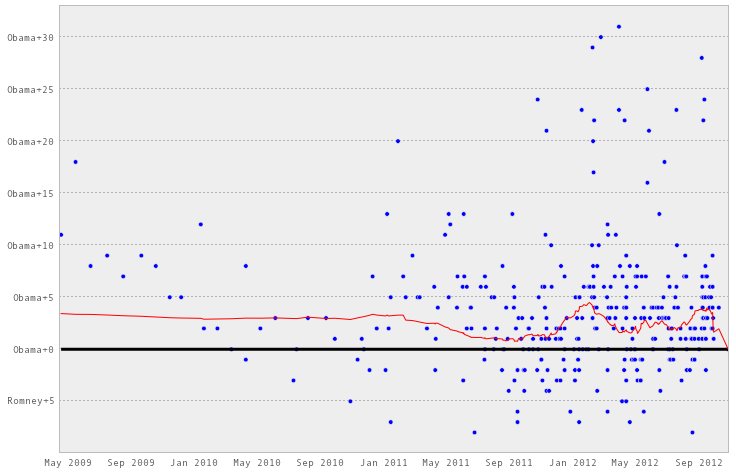

In [143]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

data = group[["poll_date", "obama_spread"]]
data = pandas.concat((data, national_data2012[["poll_date", "obama_spread"]]))
    
data.sort("poll_date", inplace=True)
dates = pandas.DatetimeIndex(data.poll_date).asi8

loess_res = sm.nonparametric.lowess(data.obama_spread.values, dates, 
                                    frac=.2, it=3)

dates_x = lib.ints_to_pydatetime(dates)
axes.scatter(dates_x, data["obama_spread"])
axes.plot(dates_x, loess_res[:,1], color='r')
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(0, dates_x[0], dates_x[-1], color='black', lw=3)
axes.margins(0, .05)

In [144]:
loess_res[-7:,1].mean()

2.3144535643345003

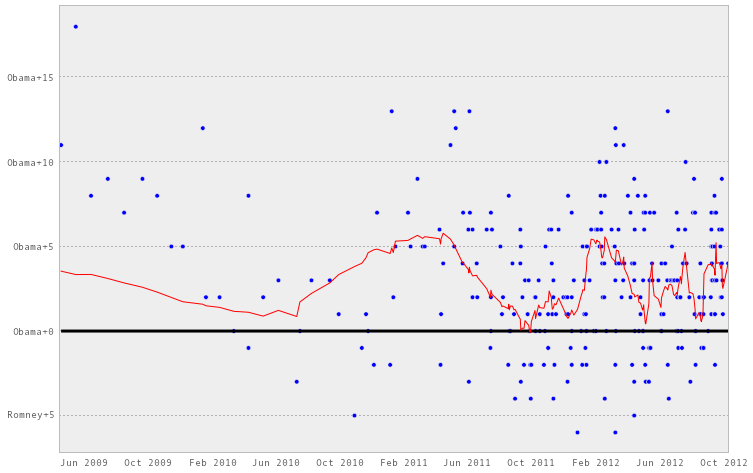

In [145]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

national_data2012.sort("poll_date", inplace=True)
dates = pandas.DatetimeIndex(national_data2012.poll_date).asi8

loess_res = sm.nonparametric.lowess(national_data2012.obama_spread.values, dates, 
                                    frac=.075, it=3)

dates_x = lib.ints_to_pydatetime(dates)
axes.scatter(dates_x, national_data2012["obama_spread"])
axes.plot(dates_x, loess_res[:,1], color='r')
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(0, dates_x[0], dates_x[-1], color='black', lw=3)
axes.margins(0, .05)

In [146]:
trends = []
for i, group in kmeans_groups:
    data = group[["poll_date", "obama_spread"]]
    data = pandas.concat((data, national_data2012[["poll_date", "obama_spread"]]))
    
    data.sort("poll_date", inplace=True)
    dates = pandas.DatetimeIndex(data.poll_date).asi8

    loess_res = sm.nonparametric.lowess(data.obama_spread.values, dates, 
                                    frac=.1, it=3)
    states = group.State.unique()
    for state in states:
        trends.append([state, loess_res[-7:,1].mean()])

In [147]:
trends

[['Arizona', 2.3149200179538716],
 ['Georgia', 2.3149200179538716],
 ['Mississippi', 2.3149200179538716],
 ['New Mexico', 2.3149200179538716],
 ['North Carolina', 2.3149200179538716],
 ['South Carolina', 2.3149200179538716],
 ['Tennessee', 2.3149200179538716],
 ['West Virginia', 2.3149200179538716],
 ['Colorado', 18.412063676088412],
 ['Connecticut', 18.412063676088412],
 ['Hawaii', 18.412063676088412],
 ['Illinois', 18.412063676088412],
 ['Maryland', 18.412063676088412],
 ['Massachusetts', 18.412063676088412],
 ['Nevada', 18.412063676088412],
 ['New Jersey', 18.412063676088412],
 ['Rhode Island', 18.412063676088412],
 ['Virginia', 18.412063676088412],
 ['Washington', 18.412063676088412],
 ['California', 2.73263672729736],
 ['Florida', 2.73263672729736],
 ['New York', 2.73263672729736],
 ['Texas', 2.73263672729736],
 ['Indiana', 6.5865280433068092],
 ['Iowa', 6.5865280433068092],
 ['Kansas', 6.5865280433068092],
 ['Maine', 6.5865280433068092],
 ['Michigan', 6.5865280433068092],
 ['Minn

#### Adjust for sensitivity to time-trends

$$\text{Margin}=X_i+Z_t+\epsilon$$

where $S_i$ are Pollster:State dummies. In a state with a time-dependent trend, you might write

$$\text{Margin}=X_i+m*Z_t$$

where $m$ is a multiplier representing uncertainty in the time-trend parameter. Solving for $m$ gives

$$m=\text{Margin}-\frac{X_i}{Z_t}$$

In [148]:
from statsmodels.formula.api import ols, wls

In [149]:
#pollster_state_dummy = state_data2012.groupby(["Pollster", "State"])["obama_spread"].mean()
#daily_dummy = state_data2012.groupby(["poll_date"])["obama_spread"].mean()

In [150]:
state_data2012["pollster_state"] = state_data2012["Pollster"] + "-" + state_data2012["State"]

There's actually a bug in pandas when you merge on datetimes. In order to avoid it, we need to sort our data now and once again after we merge on dates.

In [151]:
state_data2012.sort(columns=["pollster_state", "poll_date"], inplace=True);

In [152]:
dummy_model = ols("obama_spread ~ C(pollster_state) + C(poll_date)", data=state_data2012).fit()

The base case is American Research Group-Colorado

In [153]:
state_data2012.irow(0)

Pollster           American Research Group
State                             Colorado
MoE                                      4
Obama (D)                               49
Romney (R)                              47
Sample                                 600
Spread                            Obama +2
obama_spread                             2
poll_date              2012-09-11 00:00:00
Weight                                0.65
PIE                                   1.76
ESS                                    173
MESS                                   173
time_weight                         0.6156
kmeans_labels                            1
pollster_state    American Research Gro...
Name: 25

In [154]:
pollster_state = state_data2012["pollster_state"].unique()
pollster_state.sort()
pollster_state_params = dummy_model.params[1:len(pollster_state)] + dummy_model.params[0]
intercept = dummy_model.params[0]
X = pandas.DataFrame(zip(pollster_state, np.r_[intercept, pollster_state_params]), 
                     columns=["pollster_state", "X"])

In [155]:
dates = state_data2012.poll_date.unique()
dates.sort()
dates_params = intercept + dummy_model.params[-len(dates):]
Z = pandas.DataFrame(zip(dates, dates_params), columns=["poll_date", "Z"])

Drop the ones less than 1.

In [156]:
Z = Z.ix[np.abs(Z.Z) > 1]

In [157]:
state_data2012 = state_data2012.merge(X, on="pollster_state", sort=False)
state_data2012 = state_data2012.merge(Z, on="poll_date", sort=False)

In [158]:
state_data2012.sort(columns=["pollster_state", "poll_date"], inplace=True);

In [159]:
state_data2012["m"] = state_data2012["obama_spread"].sub(state_data2012["X"].div(state_data2012["Z"]))

In [160]:
#m_dataframe.ix[m_dataframe.pollster_state == "American Research Group-New Hampshire"].values

In [161]:
m_dataframe = state_data2012[["State", "m", "poll_date", "Pollster", "pollster_state"]]

In [162]:
m_dataframe["m"].describe()

count    355.000
mean       3.281
std        9.168
min      -52.000
25%       -0.808
50%        2.697
75%        8.145
max       38.723

In [163]:
m_size = m_dataframe.groupby("pollster_state").size()

In [164]:
m_size

pollster_state
American Research Group-Colorado               1
American Research Group-Florida                1
American Research Group-Iowa                   1
American Research Group-Nevada                 1
American Research Group-New Hampshire          3
American Research Group-North Carolina         1
American Research Group-Ohio                   1
American Research Group-Virginia               1
CNN / Opinion Research-Wisconsin               1
Chicago Trib. / MarketShares-Illinois          1
Columbus Dispatch (OH)-Ohio                    2
EPIC-MRA-Michigan                              8
Fairleigh-Dickinson (NJ)-New Jersey            3
Field Poll (CA)-California                     6
Insider Advantage-Georgia                      2
LA Times / Bloomberg-New Hampshire             1
Marist (NY)-New York                           3
Mason-Dixon-Florida                            3
Mason-Dixon-Georgia                            1
Mason-Dixon-New Hampshire                      1
Mason

In [165]:
drop_idx = m_size.ix[m_size == 1]

In [166]:
m_dataframe = m_dataframe.set_index(["pollster_state", "poll_date"])

In [167]:
m_dataframe.xs("American Research Group-New Hampshire", level=0)

                    State      m                 Pollster
poll_date                                                
2012-03-17  New Hampshire  6.437  American Research Group
2012-06-23  New Hampshire  0.071  American Research Group
2012-09-26  New Hampshire  4.055  American Research Group

In [168]:
m_dataframe = m_dataframe.drop(drop_idx.index, level=0).reset_index()

In [169]:
m_dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns:
pollster_state    320  non-null values
poll_date         320  non-null values
State             320  non-null values
m                 320  non-null values
Pollster          320  non-null values
dtypes: datetime64[ns](1), float64(1), object(3)

In [170]:
m_regression_data = m_dataframe.merge(demo_data, on="State")

In [171]:
m_regression_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns:
pollster_state    320  non-null values
poll_date         320  non-null values
State             320  non-null values
m                 320  non-null values
Pollster          320  non-null values
per_black         320  non-null values
per_hisp          320  non-null values
per_white         320  non-null values
educ_hs           320  non-null values
educ_coll         320  non-null values
average_income    320  non-null values
median_income     320  non-null values
pop_density       320  non-null values
vote_pop          320  non-null values
older_pop         320  non-null values
dem_adv           320  non-null values
no_party          320  non-null values
PVI               320  non-null values
obama_give        320  non-null values
romney_give       320  non-null values
kmeans_group      320  non-null values
kmeans_labels     320  non-null values
dtypes: datetime64[ns](1), float64(14), int64(4), object

In [172]:
m_regression_data[["PVI", "per_black", "per_hisp", "older_pop", "average_income", 
                   "romney_give", "obama_give", "educ_coll", "educ_hs"]].corr()

                  PVI  per_black  per_hisp  older_pop  average_income  romney_give  obama_give  educ_coll  educ_hs
PVI             1.000     -0.295     0.115      0.150           0.594        0.291       0.669      0.494    0.226
per_black      -0.295      1.000    -0.174      0.279          -0.064        0.111      -0.281     -0.111   -0.497
per_hisp        0.115     -0.174     1.000      0.403           0.098        0.289       0.306      0.112   -0.566
older_pop       0.150      0.279     0.403      1.000           0.022        0.237      -0.038     -0.076   -0.479
average_income  0.594     -0.064     0.098      0.022           1.000        0.718       0.704      0.888    0.250
romney_give     0.291      0.111     0.289      0.237           0.718        1.000       0.555      0.630   -0.025
obama_give      0.669     -0.281     0.306     -0.038           0.704        0.555       1.000      0.835    0.085
educ_coll       0.494     -0.111     0.112     -0.076           0.888        0.6

In [173]:
(today - m_regression_data["poll_date"].astype('O'))

0     743 days, 0:00:00
1     612 days, 0:00:00
2     521 days, 0:00:00
3     227 days, 0:00:00
4     136 days, 0:00:00
5      70 days, 0:00:00
6      24 days, 0:00:00
7     203 days, 0:00:00
8      98 days, 0:00:00
9       7 days, 0:00:00
10    391 days, 0:00:00
11    316 days, 0:00:00
12    235 days, 0:00:00
13    130 days, 0:00:00
14     97 days, 0:00:00
...
305     29 days, 0:00:00
306       1 day, 0:00:00
307    584 days, 0:00:00
308    500 days, 0:00:00
309    409 days, 0:00:00
310    220 days, 0:00:00
311     87 days, 0:00:00
312     13 days, 0:00:00
313    342 days, 0:00:00
314    218 days, 0:00:00
315    189 days, 0:00:00
316    146 days, 0:00:00
317    112 days, 0:00:00
318     69 days, 0:00:00
319     15 days, 0:00:00
Name: poll_date, Length: 320

In [174]:
time_weights = (today - m_regression_data["poll_date"].astype('O')).apply(exp_decay)

In [175]:
m_model = wls("m ~ PVI + per_hisp + per_black + average_income + educ_coll", data=m_regression_data, weights=time_weights).fit()
m_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      m   R-squared:                       0.704
Model:                            WLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     149.4
Date:                Fri, 26 Oct 2012   Prob (F-statistic):           8.75e-81
Time:                        08:31:09   Log-Likelihood:                -632.76
No. Observations:                 320   AIC:                             1278.
Df Residuals:                     314   BIC:                             1300.
Df Model:                           5                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.5623      2.504      1.822      0.069        -0.364     9.488
PVI                1.5534      0.076     20.565      0.000         1.405     1.702
per_hisp           0.1672      0.023      7.351      0.000         0.122     0.212
per_black          0.1972      0.040      4.954      0.000         0.119     0.275
average_income    -0.0003      0.000     -1.836      0.067        -0.001  2.17e-05
educ_coll          0.0612      0.121      0.506      0.613        -0.177     0.299
==============================================================================
Omnibus:                      113.511   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1263.298
Skew:                          -1.115   Prob(JB):                    4.77e-275
Kurtosis:                      12.475   Cond. No.                     2.71e+05
==============================================================================

The condition number is large, 2.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [176]:
state_resid = pandas.DataFrame(zip(m_model.resid, m_regression_data.State), 
                               columns=["resid", "State"])

In [177]:
state_resid_group = state_resid.groupby("State")

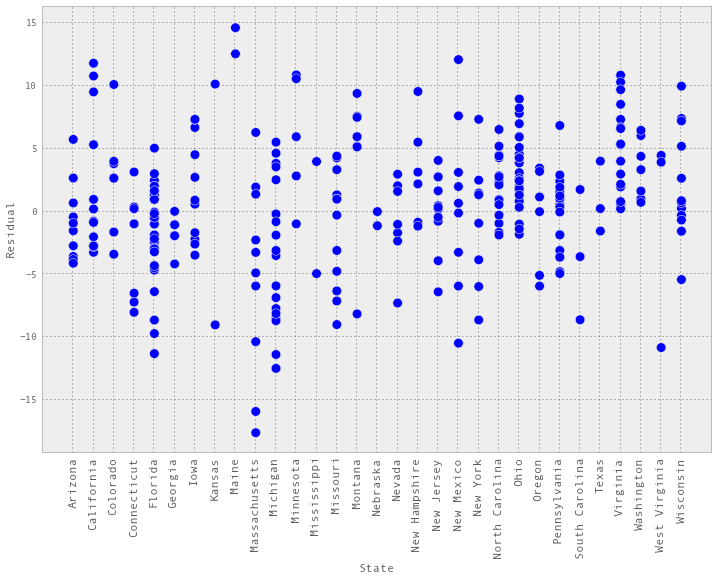

In [178]:
fig, axes = plt.subplots(figsize=(12,8), subplot_kw={"ylabel" : "Residual",
                                                     "xlabel" : "State"})
i = 0
for state, group in state_resid_group:
    x = [i] * len(group)
    axes.scatter(x, group["resid"], s=91)
    i += 1
states = m_regression_data.State.unique()
states.sort()
#axes.xaxis.get_major_locator().set_params(nbins=len(states))
axes.margins(.05, .05)
axes.xaxis.set_ticks(range(31))
axes.xaxis.set_ticklabels(states);
for label in axes.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize('large')

In [179]:
demo_data = demo_data.drop(demo_data.index[demo_data['State'] == 'District of Columbia'])
demo_data.reset_index(drop=True, inplace=True);

In [180]:
exog = demo_data[["PVI", "per_hisp", "per_black", "average_income", "educ_coll"]]
exog["const"] = 1

In [181]:
state_m = m_model.predict(exog)

In [182]:
state_m

array([-15.3603, -21.5913,  -4.9947, -10.5032,  16.1222,   1.9831,
        10.9647,  14.0814,   2.0932,  -4.6139,  18.2001, -25.0872,
        15.766 ,  -7.7724,   1.4341, -17.1113, -14.4254,  -9.5522,
         6.7645,  17.5081,  18.4677,   8.2765,   2.5286,  -7.98  ,
        -3.1192, -11.1954, -19.0509,   5.3332,   0.9212,   8.2565,
        10.5848,  19.1612,  -1.7616, -16.5408,  -0.1307, -24.3894,
         7.0121,   4.3192,  18.3818,  -7.0588, -14.4   , -11.0846,
        -8.1381, -29.2403,  18.9684,  -0.9221,   7.9232, -12.3191,
         3.498 , -31.7474])

In [183]:
unit_m = (state_m - state_m.min())/(state_m.max() - state_m.min())

In [184]:
unit_m *= 2

In [185]:
m_correction = zip(demo_data.State, unit_m)

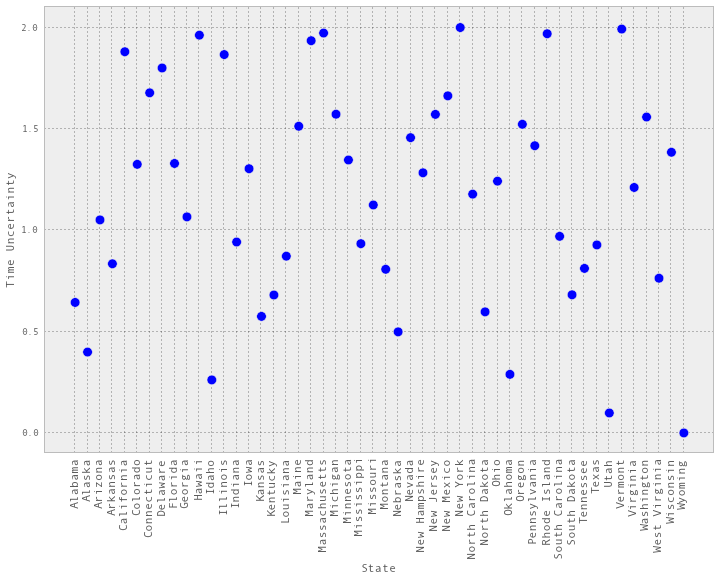

In [186]:
fig, axes = plt.subplots(figsize=(12,8), subplot_kw={"ylabel" : "Time Uncertainty",
                                                     "xlabel" : "State"})

axes.scatter(range(len(unit_m)), unit_m, s=91)

axes.margins(.05, .05)
axes.xaxis.set_ticks(range(len(unit_m)))
axes.xaxis.set_ticklabels(demo_data.State);
for label in axes.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize('large')

In [187]:
m_correction

[('Alabama', 0.64378739293503406),
 ('Alaska', 0.39899365289624461),
 ('Arizona', 1.0510086330835007),
 ('Arkansas', 0.83460144787235913),
 ('California', 1.8806123579140055),
 ('Colorado', 1.3251405679451049),
 ('Connecticut', 1.6779924829159023),
 ('Delaware', 1.8004372432963116),
 ('Florida', 1.329465611597048),
 ('Georgia', 1.0659702728954288),
 ('Hawaii', 1.9622429470675198),
 ('Idaho', 0.26165481506057381),
 ('Illinois', 1.8666167182198876),
 ('Indiana', 0.94188345895010406),
 ('Iowa', 1.3035708167337279),
 ('Kansas', 0.57499466689906564),
 ('Kentucky', 0.68051576608007691),
 ('Louisiana', 0.87196446188500021),
 ('Maine', 1.5129826861514035),
 ('Maryland', 1.9350556925421645),
 ('Massachusetts', 1.972758329102086),
 ('Michigan', 1.572382623529095),
 ('Minnesota', 1.3465700819595314),
 ('Mississippi', 0.9337304745438173),
 ('Missouri', 1.1246911889623949),
 ('Montana', 0.80740786234605832),
 ('Nebraska', 0.49879580201830931),
 ('Nevada', 1.4567544736098006),
 ('New Hampshire', 1.2

In [188]:
trends = pandas.DataFrame(trends, columns=["State", "trend"])
m_correction = pandas.DataFrame(m_correction, columns=["State", "m_correction"])

In [189]:
trends = trends.merge(m_correction, on="State")

In [190]:
trends.set_index("State", inplace=True)

                 trend  m_correction
State                               
Arizona          2.315         1.051
California       2.733         1.881
Colorado        18.412         1.325
Connecticut     18.412         1.678
Florida          2.733         1.329
Georgia          2.315         1.066
Hawaii          18.412         1.962
Illinois        18.412         1.867
Indiana          6.587         0.942
Iowa             6.587         1.304
Kansas           6.587         0.575
Maine            6.587         1.513
Maryland        18.412         1.935
Massachusetts   18.412         1.973
Michigan         6.587         1.572
Minnesota        6.587         1.347
Mississippi      2.315         0.934
Missouri         6.587         1.125
Montana          6.587         0.807
Nebraska         6.587         0.499
Nevada          18.412         1.457
New Hampshire    6.587         1.283
New Jersey      18.412         1.572
New Mexico       2.315         1.663
New York         2.733         2.000
N

In [191]:
trends = trends.product(axis=1)

### Snapshot: Combine Trend Estimates and State Polls

In [192]:
state_polls.name = "poll"
state_polls

State  Pollster                    
AZ     Public Policy Polling (PPP)     -9.168
       Rasmussen                      -10.209
CA     Field Poll (CA)                 23.344
       Public Policy Polling (PPP)     20.999
       Rasmussen                       22.000
       SurveyUSA                       22.123
CO     American Research Group          2.000
       Public Policy Polling (PPP)      5.470
       Rasmussen                       -1.574
CT     Public Policy Polling (PPP)     12.758
       Quinnipiac                       7.294
       Rasmussen                        8.000
FL     American Research Group          5.000
       Mason-Dixon                     -3.543
       Public Policy Polling (PPP)      3.125
       Quinnipiac                       3.076
       Rasmussen                        0.883
       Suffolk (NH/MA)                 -0.003
       SurveyUSA                        4.169
GA     Insider Advantage              -19.174
       Mason-Dixon                    -17.00

In [193]:
state_polls = state_polls.reset_index()
state_polls.State = state_polls.State.replace(states_abbrev_dict)

In [194]:
trends.name = "poll"
trends

State
Arizona            2.433
California         5.139
Colorado          24.399
Connecticut       30.895
Florida            3.633
Georgia            2.468
Hawaii            36.129
Illinois          34.368
Indiana            6.204
Iowa               8.586
Kansas             3.787
Maine              9.965
Maryland          35.628
Massachusetts     36.323
Michigan          10.357
Minnesota          8.869
Mississippi        2.162
Missouri           7.408
Montana            5.318
Nebraska           3.285
Nevada            26.822
New Hampshire      8.453
New Jersey        28.936
New Mexico         3.850
New York           5.465
North Carolina     2.727
North Dakota       3.935
Ohio               8.181
Oregon            10.029
Pennsylvania       9.333
Rhode Island      36.260
South Carolina     2.245
South Dakota       4.489
Tennessee          1.879
Texas              2.535
Utah               0.649
Vermont           13.123
Virginia          22.297
Washington        28.695
West Virginia      

In [195]:
trends = trends.reset_index()
trends["Pollster"] = "National"

In [196]:
trends

             State    poll  Pollster
0          Arizona   2.433  National
1       California   5.139  National
2         Colorado  24.399  National
3      Connecticut  30.895  National
4          Florida   3.633  National
5          Georgia   2.468  National
6           Hawaii  36.129  National
7         Illinois  34.368  National
8          Indiana   6.204  National
9             Iowa   8.586  National
10          Kansas   3.787  National
11           Maine   9.965  National
12        Maryland  35.628  National
13   Massachusetts  36.323  National
14        Michigan  10.357  National
15       Minnesota   8.869  National
16     Mississippi   2.162  National
17        Missouri   7.408  National
18         Montana   5.318  National
19        Nebraska   3.285  National
20          Nevada  26.822  National
21   New Hampshire   8.453  National
22      New Jersey  28.936  National
23      New Mexico   3.850  National
24        New York   5.465  National
25  North Carolina   2.727  National
2

In [197]:
polls = pandas.concat((state_polls, trends))

In [198]:
weights

                    Pollster  Weight   PIE
0      ABC / Washington Post    0.95  1.41
1    American Research Group    0.65  1.76
2       CBS / New York Times    0.66  1.84
3   Chicago Trib. / Marke...    1.16  1.13
4     CNN / Opinion Research    0.77  1.59
5     Columbus Dispatch (OH)    0.50  6.76
6                   EPIC-MRA    0.75  1.65
7   Fairleigh-Dickinson (NJ)    0.71  1.72
8            Field Poll (CA)    1.33  0.88
9     Fox / Opinion Dynamics    0.79  1.60
10      Franklin Pierce (NH)    0.74  1.60
11         Insider Advantage    0.95  1.29
12             Keystone (PA)    0.64  1.55
13      LA Times / Bloomberg    0.83  1.44
14               Marist (NY)    0.69  1.73
15               Mason-Dixon    1.10  1.15
16                  Mitchell    0.96  1.43
17                 Ohio Poll    1.24  1.05
18  Public Opinion Strate...    0.63  1.81
19  Public Policy Polling...    1.05  1.60
20                Quinnipiac    0.95  1.34
21                 Rasmussen    1.30  0.88
22         

In [199]:
natl_weight = pandas.DataFrame([["National", weights.Weight.mean(), weights.PIE.mean()]],
                                columns=["Pollster", "Weight", "PIE"])
weights = pandas.concat((weights, natl_weight)).reset_index(drop=True)

In [200]:
polls = polls.merge(weights, on="Pollster", how="left")

In [201]:
polls = polls.sort("State")

In [202]:
def weighted_mean(group):
    return (group["poll"] * group["Weight"] / group["Weight"].sum()).sum()

In [203]:
group

     resid      State
307  5.193  Wisconsin
308  7.402  Wisconsin
309  0.246  Wisconsin
310  9.971  Wisconsin
311  0.697  Wisconsin
312  2.648  Wisconsin
313 -0.300  Wisconsin
314  0.859  Wisconsin
315  7.209  Wisconsin
316 -0.676  Wisconsin
317 -5.412  Wisconsin
318 -1.565  Wisconsin
319 -1.565  Wisconsin

In [204]:
results = polls.groupby("State").aggregate(weighted_mean)["poll"]

In [205]:
results

State
Arizona           -6.351
California        19.794
Colorado           6.947
Connecticut       13.967
Florida            2.079
Georgia           -8.969
Hawaii            31.233
Illinois          26.869
Indiana           -6.870
Iowa               2.325
Kansas            -9.541
Maine             12.734
Maryland          28.856
Massachusetts     21.816
Michigan           8.561
Minnesota          8.046
Mississippi       -8.637
Missouri          -1.974
Montana           -7.035
Nebraska          -8.663
Nevada             9.022
New Hampshire     -1.133
New Jersey        13.545
New Mexico         9.145
New York          23.207
North Carolina    -0.590
North Dakota      -9.138
Ohio               4.384
Oregon             9.117
Pennsylvania       5.692
Rhode Island      25.931
South Carolina    -6.767
South Dakota      -1.136
Tennessee         -2.883
Texas             -2.578
Utah             -29.142
Vermont           16.811
Virginia           4.985
Washington        16.118
West Virginia     -

In [206]:
results = results.reset_index()
results["obama"] = 0
results["romney"] = 0
results.ix[results["poll"] > 0, ["obama"]] = 1
results.ix[results["poll"] < 0, ["romney"]] = 1

In [ ]:
results[["State", "poll"]].to_csv("/home/skipper/school/talks/538model/2012-predicted.csv", index=False)

In [207]:
electoral_votes = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/electoral_votes.csv")

In [208]:
electoral_votes.sort("State", inplace=True).reset_index(drop=True, inplace=True)

                   State  Votes
0                Alabama      9
1                 Alaska      3
2                Arizona     11
3               Arkansas      6
4             California     55
5               Colorado      9
6            Connecticut      7
7               Delaware      3
8   District of Columbia      3
9                Florida     29
10               Georgia     16
11                Hawaii      4
12                 Idaho      4
13              Illinois     20
14               Indiana     11
15                  Iowa      6
16                Kansas      6
17              Kentucky      8
18             Louisiana      8
19                 Maine      4
20              Maryland     10
21         Massachusetts     11
22              Michigan     16
23             Minnesota     10
24           Mississippi      6
25              Missouri     10
26               Montana      3
27              Nebraska      5
28                Nevada      6
29         New Hampshire      4
30      

In [209]:
results = electoral_votes.merge(results, on="State", how="left")

In [210]:
results = results.set_index("State")
red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Kentucky", "Louisiana",
              "Oklahoma", "Wyoming"]
blue_states = ["Delaware", "District of Columbia"]
results.ix[red_states, ["romney"]] = 1
results.ix[red_states, ["obama"]] = 0
results.ix[blue_states, ["obama"]] = 1
results.ix[blue_states, ["romney"]] = 0

In [211]:
results

                      Votes    poll  obama  romney
State                                             
Alabama                   9     NaN      0       1
Alaska                    3     NaN      0       1
Arizona                  11  -6.351      0       1
Arkansas                  6     NaN      0       1
California               55  19.794      1       0
Colorado                  9   6.947      1       0
Connecticut               7  13.967      1       0
Delaware                  3     NaN      1       0
District of Columbia      3     NaN      1       0
Florida                  29   2.079      1       0
Georgia                  16  -8.969      0       1
Hawaii                    4  31.233      1       0
Idaho                     4     NaN      0       1
Illinois                 20  26.869      1       0
Indiana                  11  -6.870      0       1
Iowa                      6   2.325      1       0
Kansas                    6  -9.541      0       1
Kentucky                  8    

In [212]:
results["Votes"].mul(results["obama"]).sum()

328.0

In [213]:
results["Votes"].mul(results["romney"]).sum()

210.0

In [214]:
results

                      Votes    poll  obama  romney
State                                             
Alabama                   9     NaN      0       1
Alaska                    3     NaN      0       1
Arizona                  11  -6.351      0       1
Arkansas                  6     NaN      0       1
California               55  19.794      1       0
Colorado                  9   6.947      1       0
Connecticut               7  13.967      1       0
Delaware                  3     NaN      1       0
District of Columbia      3     NaN      1       0
Florida                  29   2.079      1       0
Georgia                  16  -8.969      0       1
Hawaii                    4  31.233      1       0
Idaho                     4     NaN      0       1
Illinois                 20  26.869      1       0
Indiana                  11  -6.870      0       1
Iowa                      6   2.325      1       0
Kansas                    6  -9.541      0       1
Kentucky                  8    

TODO:

Divide undecided voters probabilistically.

Do historical adjustments based on how polls changed in the past conditional on "election environment"

"Error analysis"